In [1]:
import numpy as np
import scipy.signal
import scipy.stats
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from latent_dynamics import *
from variational import *
from normalizing_flow import *
from visualization import *

from tqdm import tqdm

# Generating Synthetic Data Set

We consider the Kalman Filter model with diagonal covariances. Latent variables are denoted by
$z_1, \ldots, z_T \in \mathbb{R}^{d}$ and observations are denoted by $x_1, \ldots, x_T \in \mathbb{R}^{m}$.

$z_1 \sim \mathcal{N}(\mu_1, \sigma_1\mathbf{I})$

$z_t \sim \mathcal{N}(\mathbf{A}z_{t-1} + b, \sigma\mathbf{I})$ for $t=2, \ldots, T$

$x_t \sim \mathcal{N}(\mathbf{C}z_t + d, s\mathbf{I})$ for $t=1, \ldots, T$

We sample $N$ examples (i.e. paths) from this generative model with fixed $\mathbf{A}, \mathbf{C}, b, d, \sigma, s$. We will use these $N$ examples for Auto Encoding Variational Bayes regime to learn a variational posterior $q_\phi(z|x)$ expressed by at dynamical normalizing flows whose parameters are a neural net function of observations $x$. Wee partition the example set $\mathbf{X} = \{x^{(n)}_1, \ldots, x^{(n)}_T\}$ 80% of the observations for training and 20% for validation.

In [2]:
N = 100 # Number of total examples
LAT_DIM = 2 # Latent space dimensions d
OBS_DIM = 3 # Observation space dimensions m
TIME = 10 # time steps T

L = 10 # Number of samples for monte carlo estimate (AEVB)

In [3]:
# Fix values for transition and emmision transformation
# Matrices A and C, the biases are randomly assigned
TRANS_MATRIX = np.array([[.1, -.4], [.1, -.2]]) * 4

emmit_mat = np.array([[1., 2., 1.], [2., 1., 1.]])

with tf.Graph().as_default():
    t1 = LinearTransform(LAT_DIM, LAT_DIM, initial_value=TRANS_MATRIX + np.eye(2))
    trans = ConditionalRandomVariable(
        dim_x=LAT_DIM, dim_y=LAT_DIM, transform=t1, noise=2)
    t2 = LinearTransform(LAT_DIM, OBS_DIM, initial_value=emmit_mat)
    emmit = ConditionalRandomVariable(
        dim_x=OBS_DIM, dim_y=LAT_DIM, transform=t2)
    seq = MarkovLatentDynamics(trans, emmit, TIME)
    samp = seq.sample(N)
    prob = seq.log_prob(samp[0], samp[1])
    print samp[0].shape, samp[1].shape
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        z_star, x_star = sess.run(samp)
        p = sess.run(prob)
        emmit_bias = sess.run(t2.bias)

(100, 20) (100, 30)


# Visualize Evolution of Latent Variables and Observations

These are what we call true evolutions. Each color indicates a 

Text(0.5,1,'Observation Space')

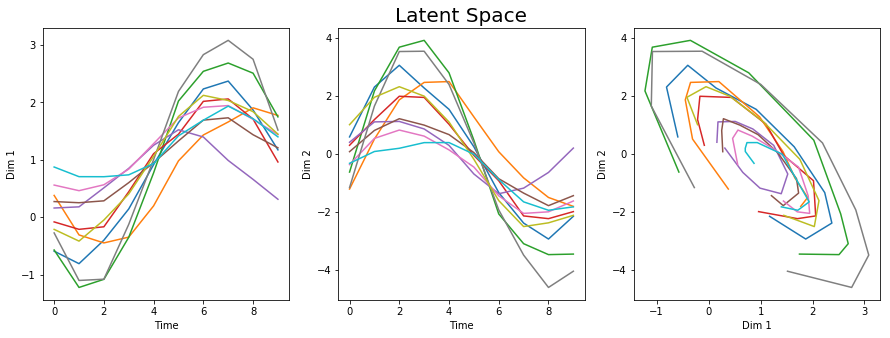

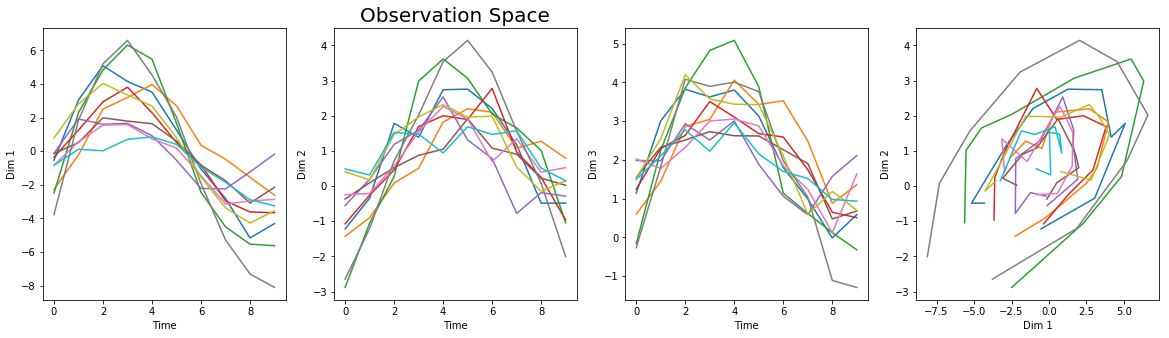

In [4]:
lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
for i in range(L):
    lin_vis_lat.add_trajectory(z_star[i, :], color='C{}'.format(i))
lin_vis_lat.ax[1].set_title('Latent Space', fontsize=20)

lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
for i in range(L):
    lin_vis_obs.add_trajectory(x_star[i, :], color='C{}'.format(i))
lin_vis_obs.ax[1].set_title('Observation Space', fontsize=20)

# Building Graph for Elbo Computation and Minimization

Here is the section that we set up the computation graph for AEVB and evidence lower bound in the form

Model $p_\theta(x, z)$ that we use is the same Kalman Filter with diagonal covariances. Therefore, $\theta = \{ \mu_1, \sigma_1, \mathbf{A}, \mathbf{C}, b, d, \sigma, s\}$

$\mathbb{E}_{q_\phi(z|x)} [\log p_\theta(x, z) - \log q_\phi(z|x)]$

where

$\log p(z, x) = log \mathcal{N}(z_1|\mu_1, \sigma_1)+ 
\sum_{t=2}^{T}
log \mathcal{N}(z_t|\mathbf{A}z_{t-1}+b, \sigma \mathbf{I})+
\sum_{t=1}^{T}
log \mathcal{N}(x_t|\mathbf{B}z_{t-1}+d, s \mathbf{I})$

In [5]:
graph = tf.Graph()
tot_iterations = 0

with graph.as_default():

    # Observation
    x = tf.placeholder(shape=[1, OBS_DIM * TIME], dtype=tf.float64, name='input')

    # Variational Model
    rec = DynaFlowConditionalRandomVariable(y=x, dim=LAT_DIM, time=TIME, num_layers=5)

    # Generative Model
    # Transition Transformation
    # The following basically is the model for a kalman filter
    # with diagonal covariances
    t1 = LinearTransform(LAT_DIM, LAT_DIM, initial_value=np.array([[1., .1], [.1, 1.]]))
    trans = ConditionalRandomVariable(
        dim_x=LAT_DIM, dim_y=LAT_DIM, transform=t1)
    # Emmision Transformation
    t2 = LinearTransform(LAT_DIM, OBS_DIM)
    emmit = ConditionalRandomVariable(dim_x=OBS_DIM, dim_y=LAT_DIM, transform=t2)
    gen = MarkovLatentDynamics(trans, emmit, TIME)

    # Sample from variational distribution for monte carlo
    sample, log_q = rec.sample_log_prob(10)

    print gen.log_prob(sample, x).shape, log_q.shape
    loss = - tf.reduce_sum(gen.log_prob(sample, x)) + tf.reduce_sum(log_q)

    # Set up the learning algorithm
    train_op = tf.train.AdagradOptimizer(learning_rate=.01).minimize(loss)
    #train_op = tf.train.AdamOptimizer(learning_rate=.1).minimize(loss)

    z_d, x_d = gen.sample(L)
    x_hat = gen.sample_observations(n_samples=20, z=sample)

    losses = []
    validation = []
    # Learning
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

(10,) (10,)


# Training The Models

We use gradients of the monte carlo estimate of ELBO we use AdaGrad for optimizing the loss. We use 80% of the examples for training and on the rest we report the loss for validation.

In [14]:
STEPS = 20000
N_TRAIN = int(N * .8)
N_VALID = N - N_TRAIN

with graph.as_default():
    for i in tqdm(range(STEPS)):
        train_idx = i % N_TRAIN
        l, _ = sess.run(
            [loss, train_op],
            feed_dict={"input:0": x_star[None, train_idx, :]})
        valid_indx = N_TRAIN + i % N_VALID
        v = sess.run(
            loss,
            feed_dict={"input:0": x_star[None, valid_indx, :]})
        losses.append(l)
        validation.append(v)
        tot_iterations += 1

100%|██████████| 20000/20000 [17:33<00:00, 18.98it/s]


# Let's Compute the Current Latent Paths and Reconstructions

In [15]:
outputs = []
with graph.as_default():
    for i in tqdm(range(N)):
        rec_, z_i, x_i, x_h = sess.run(
            [sample, z_d, x_d, x_hat],
            feed_dict={"input:0": x_star[np.newaxis, i, :]})
        outputs.append([rec_, z_i, x_i, x_h])
    A_, b_ = sess.run(
        [t2.lin_trans, t2.bias])

100%|██████████| 100/100 [00:01<00:00, 85.69it/s]


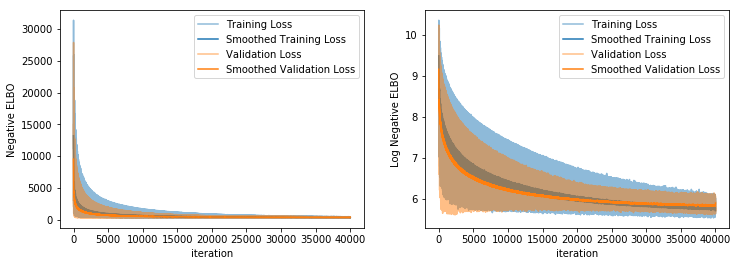

In [16]:
def smooth(x):
    return scipy.signal.savgol_filter(x, window_length=101, polyorder=3)

fig, ax = plt.subplots(1, 2)
ax[0].plot(losses, alpha=0.5)
ax[0].plot(smooth(np.array(losses)), color='C0')
ax[0].plot(validation, alpha=0.5)
ax[0].plot(smooth(np.array(validation)), color='C1')
ax[0].set_ylabel('Negative ELBO')

ax[1].plot(np.log(np.array(losses)), alpha=0.5)
ax[1].plot(np.log(np.array(smooth(losses))), color='C0')
ax[1].plot(np.log(np.array(validation)), alpha=0.5)
ax[1].plot(np.log(np.array(smooth(validation))), color='C1')
ax[1].set_ylabel('Log Negative ELBO')

for i in range(2):
    ax[i].set_xlabel('iteration')
    ax[i].legend(['Training Loss', 'Smoothed Training Loss', 'Validation Loss', 'Smoothed Validation Loss'])
fig.set_size_inches(12, 4)

In [17]:
recs_ = np.squeeze(np.array([e[0] for e in outputs])[:, 0, :])
z_draw = np.squeeze(np.array([e[1] for e in outputs])[:, 0, :])
x_draw = np.squeeze(np.array([e[2] for e in outputs])[:, 0, :])

print recs_.shape, z_draw.shape, x_draw.shape

(100, 20) (100, 20) (100, 30)


In [18]:
def rotate(z):
    z_ = z.reshape([z.shape[0], TIME, LAT_DIM])
    z_ = np.matmul(z_, A_) + b_
    z_ = np.matmul(z_ - emmit_bias, np.linalg.pinv(emmit_mat))
    return z_.reshape([z_.shape[0], TIME * LAT_DIM])

Text(0.5,1,'Observation Space')

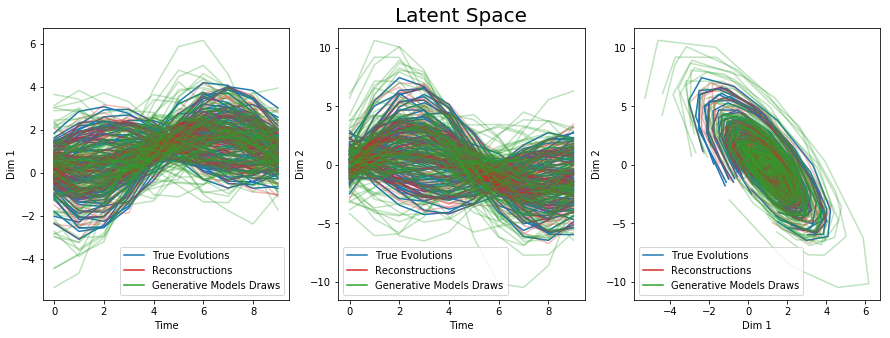

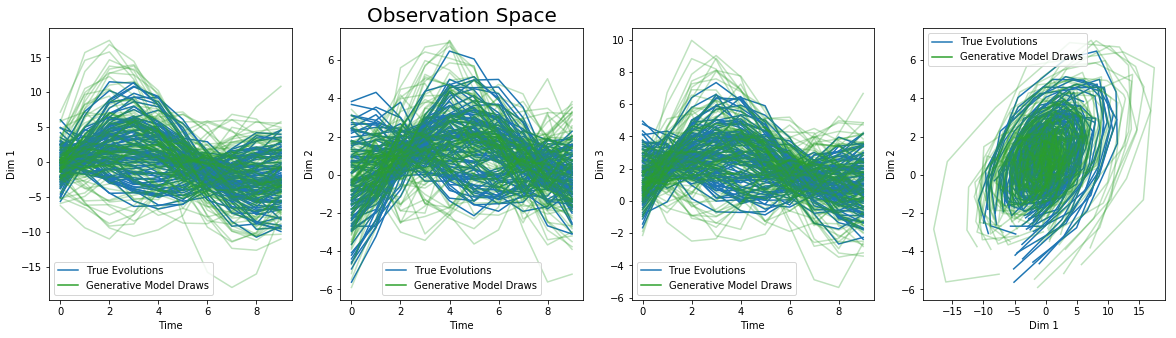

In [22]:
lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
lin_vis_lat.add_trajectory(z_star[:, :], color='C0')
lin_vis_lat.add_trajectory(rotate(recs_), color='C3', alpha=0.3)
lin_vis_lat.add_trajectory(rotate(np.squeeze(z_draw)), color='C2', alpha=0.3)
legend_elements = [Line2D([0], [0], color='C0', label='True Evolutions'),
                   Line2D([0], [0], color='C3', label='Reconstructions'),
                   Line2D([0], [0], color='C2', label='Generative Models Draws'),]
for i in range(3):
    lin_vis_lat.ax[i].legend(handles=legend_elements)
lin_vis_lat.ax[1].set_title('Latent Space', fontsize=20)

lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
lin_vis_obs.add_trajectory(x_star[:, :], color='C0')
lin_vis_obs.add_trajectory(np.squeeze(x_draw), color='C2', alpha=0.3)

legend_elements = [Line2D([0], [0], color='C0', label='True Evolutions'),
                   Line2D([0], [0], color='C2', label='Generative Model Draws'),]
for i in range(4):
    lin_vis_obs.ax[i].legend(handles=legend_elements)
lin_vis_obs.ax[1].set_title('Observation Space', fontsize=20)

# Individual Paths, their Codes and Reconstructions for Validation Set

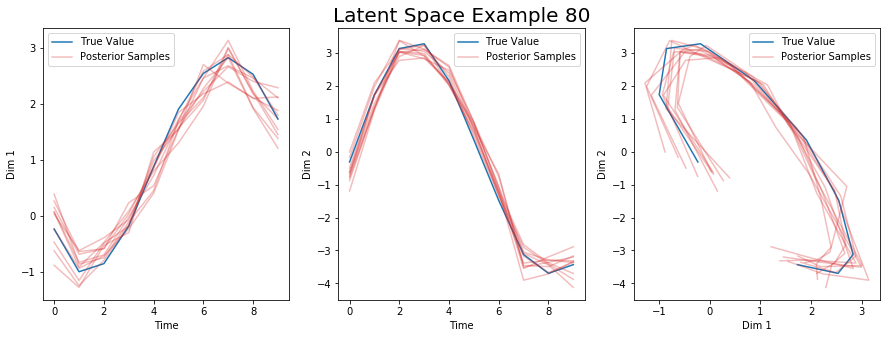

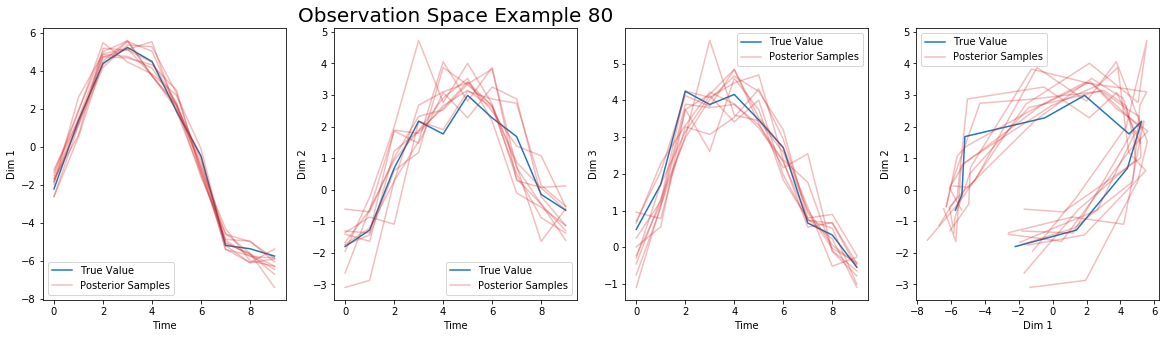

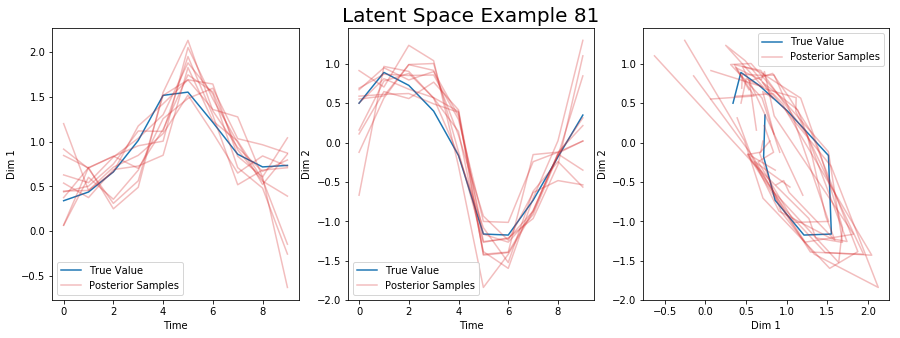

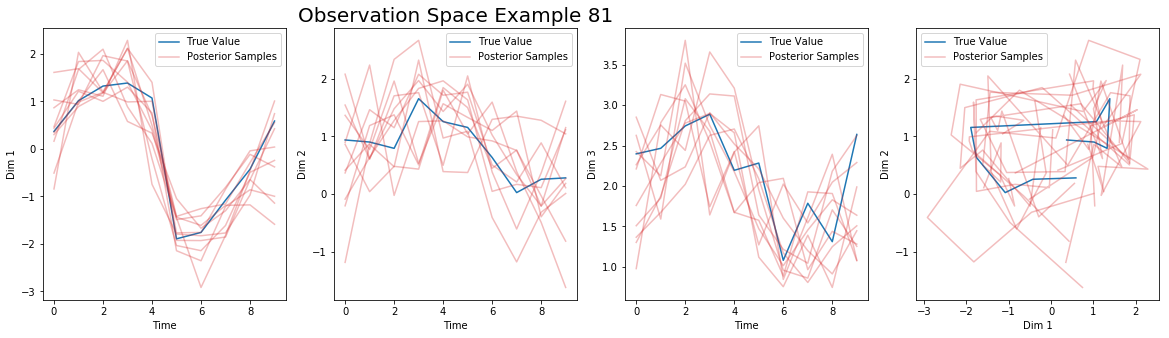

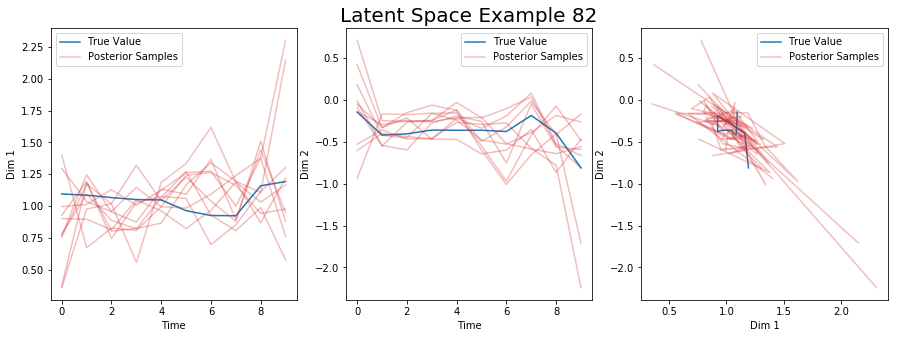

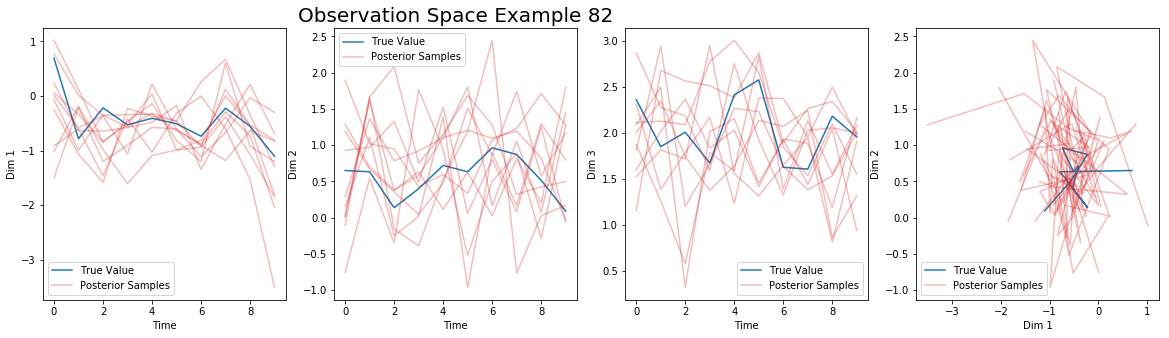

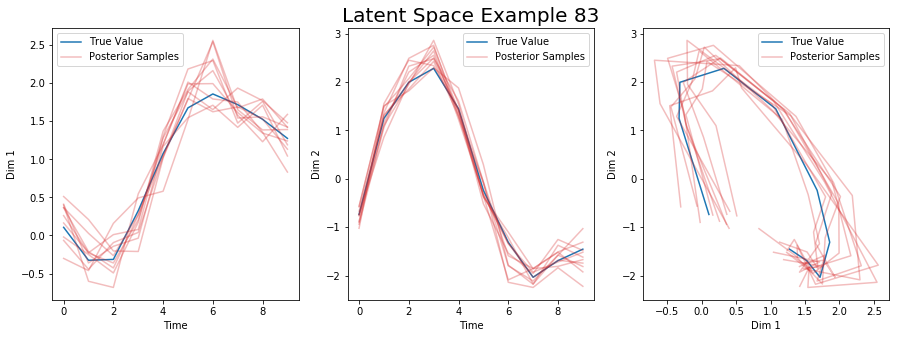

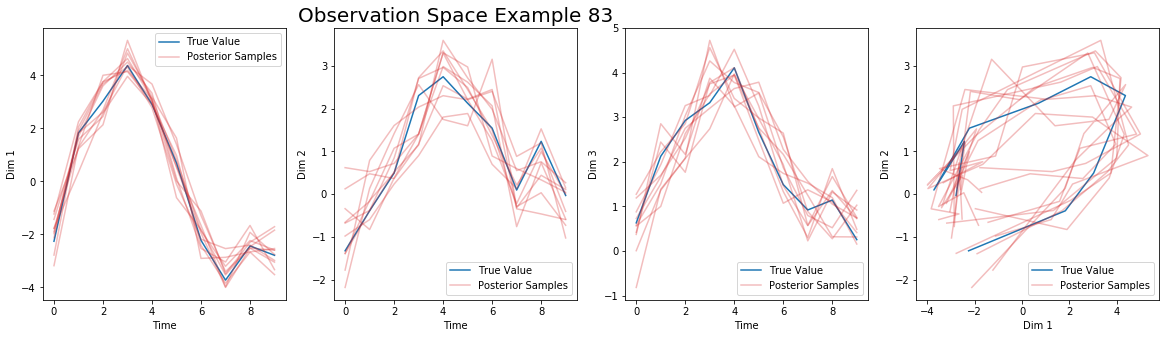

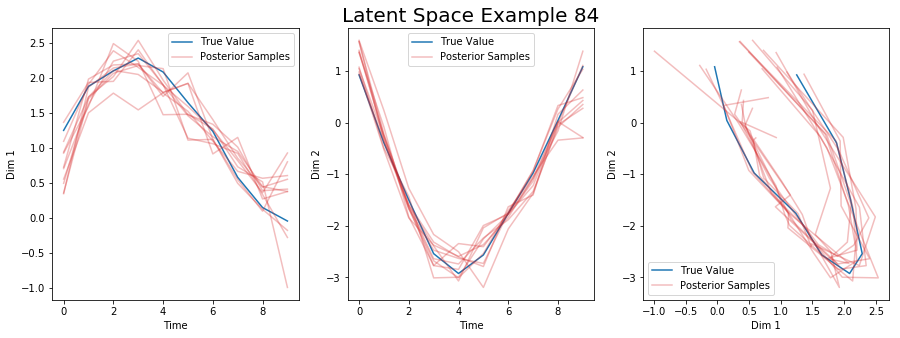

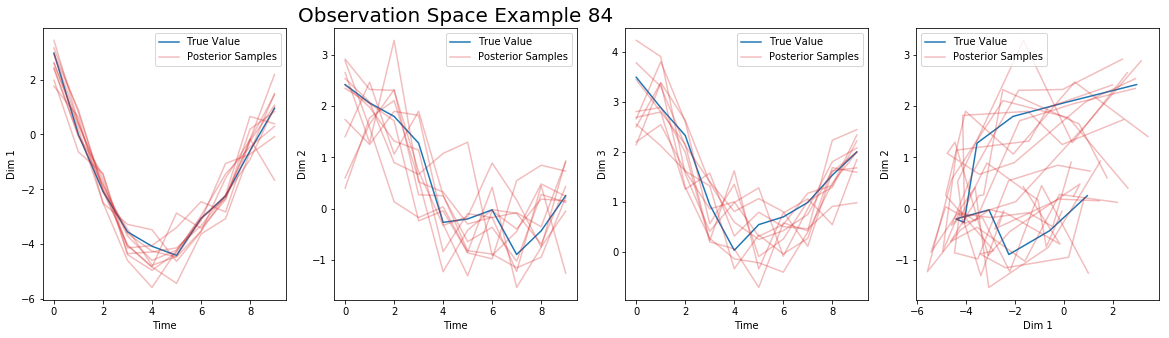

In [24]:
for sample_idx in range(N_TRAIN, N_TRAIN + 5):

    z_h_ = np.squeeze(np.array([e[0] for e in outputs])[sample_idx, :, :])
    x_h_ = np.squeeze(np.array([e[3] for e in outputs])[sample_idx, :, :])

    lin_vis_lat = DynamicalSystemVisualizer(dim=LAT_DIM, time_steps=TIME)
    lin_vis_lat.add_trajectory(z_star[sample_idx:sample_idx + 1, :], color='C0')
    lin_vis_lat.add_trajectory(rotate(z_h_), color='C3', alpha=0.3)
    for i in range(3):
        lin_vis_lat.ax[i].legend(['True Value', 'Posterior Samples'])
    #lin_vis_lat.add_trajectory(np.squeeze(z_draw), color='C2', alpha=0.1)
    lin_vis_lat.ax[1].set_title('Latent Space Example {}'.format(sample_idx), fontsize=20)


    lin_vis_obs = DynamicalSystemVisualizer(dim=OBS_DIM, time_steps=TIME)
    lin_vis_obs.add_trajectory(x_star[sample_idx:sample_idx + 1, :], color='C0')
    lin_vis_obs.add_trajectory(np.squeeze(x_h_), color='C3', alpha=0.3)

    for i in range(4):
        lin_vis_obs.ax[i].legend(['True Value', 'Posterior Samples'])
    lin_vis_obs.ax[1].set_title('Observation Space Example {}'.format(sample_idx), fontsize=20)
    

In [25]:
sess.close()